In [ ]:
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P "/data3/mgaur/sam2/checkpoints"

**NOTE:** This code enables mixed-precision computing for faster deep learning. It uses bfloat16 for most calculations and, on newer NVIDIA GPUs, leverages TensorFloat-32 (TF32) for certain operations to further boost performance.

In [ ]:
if os.path.isdir("/storage/users/manugaur"):
    data_dir = "/storage/users/manugaur"
elif os.path.isdir("/workspace/manugaur"):
    data_dir = "/workspace/manugaur"
elif os.path.isdir("/data3/mgaur/mllm_inversion"):
    data_dir = "/data3/mgaur/mllm_inversion"
else:
    raise Exception("input data dir bruh")


def get_coco_path(cocoid_img_name):
    if '.jpg' not in cocoid_img_name:
        cocoid_img_name += '.jpg'
    image_path = os.path.join(data_dir, 'coco', cocoid_img_name.split("_")[1], cocoid_img_name)
    if os.path.isfile(image_path):
        return image_path
    else:
        raise Exception("COCO image not found")

def get_vg_path(vg_id):
    img_name = vg_id + ".jpg"
    pathA = os.path.join(data_dir, "visual_genome_non_coco/VG_100K_2", img_name)
    pathB = os.path.join(data_dir, "visual_genome_non_coco/VG_100K", img_name)
    if os.path.isfile(pathA):
        return pathA
    elif os.path.isfile(pathB):
        return pathB
    else:
        raise Exception("VG image not found")
def get_mapillary_path(uid):
    img_path = os.path.join(data_dir, 'mapillary/images', uid + ".jpg")
    if os.path.isfile(img_path):
        return img_path
    else:
        raise Exception(f"{img_path} not found")


In [7]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
def plot_binary_mask(mask):
    fig, ax = plt.subplots()
    ax.imshow(np.asarray(mask), cmap='gray')
    ax.axis('off')
    fig.tight_layout()
    plt.show()

In [58]:
split = 'train'
df = pd.read_parquet(f"/data3/mgaur/mllm_inversion/datasets/combined_df_2.4m_{split}_preproc_fixed_bbox_format_no_paco_no_cocostuff.parquet")

woman in white shirt looking down at laptop computer


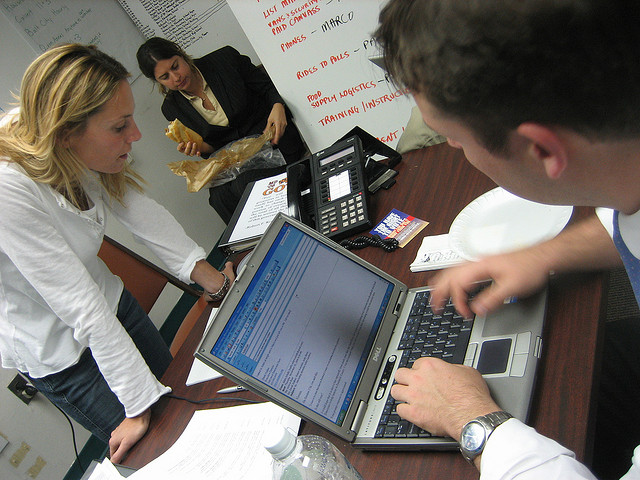

In [59]:
idx = 1
uid, ref, bbox, cocoid, dataset, dataset_sample_idx, mask_rle_box, cap_len, og_df_index = tuple(df.iloc[idx])
print(ref)
# Pick image path
if cocoid is not None:
    img_path = get_coco_path(cocoid)
elif dataset == "visual genome":
    img_path = get_vg_path(uid)
elif dataset == "mapillary DA":
    img_path = get_mapillary_path(uid)
else:
    raise Exception("__getitem__ error: image from unknown dataset")

Image.open(img_path)

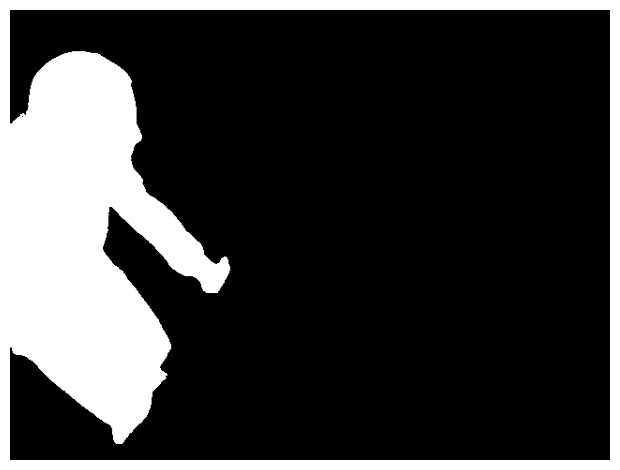

In [63]:
plot_binary_mask(torch.load(f'/home/mgaur/train/{idx}.pt'))

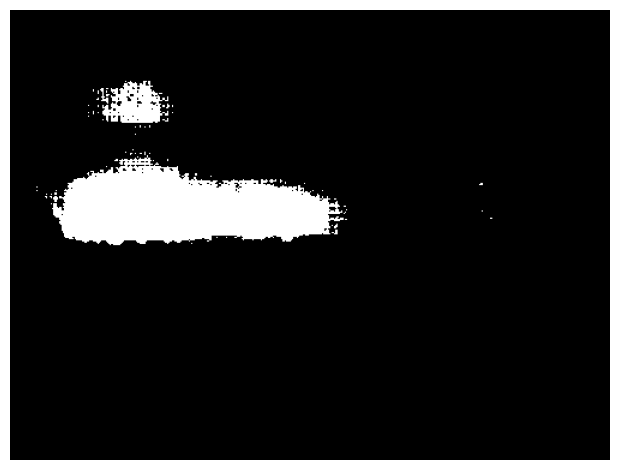

In [60]:
plot_binary_mask(torch.load(f'/data3/mgaur/mllm_inversion/seg_masks/{split}/{idx}.pt'))

In [64]:
np.array(Image.open(img_path)).shape

(480, 640, 3)

In [65]:
torch.load(f'/home/mgaur/train/{idx}.pt').shape

torch.Size([480, 640])

In [ ]:
import os
import pandas as pd
import random
import numpy as np
import torch

num_points = 2
def get_bbox_or_point_df(df, num_points):
    mask = df['bbox'].apply(
        lambda x: (
            isinstance(x, (list, tuple)) and len(x) == num_points
        ) or (
            isinstance(x, np.ndarray) and x.ndim == 1 and x.size == num_points
        )
    )
    return df[mask]

df_path = "/data3/mgaur/mllm_inversion/datasets/combined_df_2.4m_train_preproc_fixed_bbox_format_no_paco_no_cocostuff.parquet"
FULL_DF = pd.read_parquet(df_path)
for _ in FULL_DF.bbox.tolist():
    if isinstance(_, str):
        raise Exception("dataframe has some bboxes stored in str format")

df = get_bbox_or_point_df(FULL_DF, num_points)
num_samples = len(df)
from matplotlib.patches import Rectangle

In [ ]:
for _ in range(10):
    idx = random.randint(0, num_samples)
    row = df.iloc[idx]
    cap = row['caption']
    uid = row['uid']
    cocoid = row['cocoid']
    dataset = row['dataset']
    bbox = row['bbox']
    
    seg_mask = torch.load(os.path.join("/data3/mgaur/mllm_inversion/seg_masks/train", f"{idx}.pt"))
    print(dataset)
    print(cap)
    if cocoid is not None:
        img_path = get_coco_path(cocoid)
    elif dataset == "visual genome":
        img_path = get_vg_path(uid)
    elif dataset =="mapillary DA":
        img_path = get_mapillary_path(uid)
    else:
        raise Exception("__getitem__ error: image from unknown dataset")
    
    img = Image.open(img_path)
    plt.figure()
    plt.imshow(img)
    if len(bbox) == 4:
        x, y, w, h = bbox
        plt.gca().add_patch(Rectangle((x, y), w, h, fill=False, linewidth=2, color='red'))
    else:  # len == 2 -> point
        x, y = bbox
        plt.scatter([x], [y], s=40, c='red', marker='x')
    plt.axis('off')
    plt.show()
    
    plot_binary_mask(seg_mask)
    print("--"*40)
    print("\n")


## huggingface batched inference


In [ ]:
#create torch dataset
#__init__
split = 'val'
df = pd.read_parquet(os.path.join(data_dir, f"datasets/combined_df_2.4m_{split}_preproc_fixed_bbox_format_no_paco_no_cocostuff.parquet"))

#__getitem__(idx)
uid, ref, bbox, cocoid, dataset, dataset_sample_idx, mask_rle_box, cap_len, og_df_index = df.iloc[idx]
if cocoid is not None:
    img_path = get_coco_path(cocoid)
elif dataset == "visual genome":
    img_path = get_vg_path(uid)
elif dataset =="mapillary DA":
    img_path = get_mapillary_path(uid)
else:
    raise Exception("__getitem__ error: image from unknown dataset")

IMAGE_PATH = img_path

if len(bbox)==4:
    x,y,w,h = bbox
    x_max = x + w
    y_max = y + h
    boxes = np.array([x,y,x_max, y_max]).reshape(1,4)
else:
    boxes = bbox

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

return image_rgb, boxes

### chatgpt loader 

In [ ]:
from transformers import Sam2Processor, Sam2Model
import torch
from PIL import Image
from accelerate import Accelerator
from tqdm import tqdm

device = Accelerator().devicew
model = Sam2Model.from_pretrained("facebook/sam2.1-hiera-large").to(device)
processor = Sam2Processor.from_pretrained("facebook/sam2.1-hiera-large")

In [30]:
import os
import cv2
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

if os.path.isdir("/storage/users/manugaur"):
    data_dir = "/storage/users/manugaur"
elif os.path.isdir("/workspace/manugaur"):
    data_dir = "/workspace/manugaur"
elif os.path.isdir("/data3/mgaur/mllm_inversion"):
    data_dir = "/data3/mgaur/mllm_inversion"
else:
    raise Exception("input data dir bruh")

def get_coco_path(cocoid_img_name: str) -> str:
    if ".jpg" not in cocoid_img_name:
        cocoid_img_name += ".jpg"
    image_path = os.path.join(
        data_dir, "coco", cocoid_img_name.split("_")[1], cocoid_img_name
    )
    if os.path.isfile(image_path):
        return image_path
    raise Exception("COCO image not found")

def get_vg_path(vg_id: str) -> str:
    img_name = vg_id + ".jpg"
    pathA = os.path.join(data_dir, "visual_genome_non_coco/VG_100K_2", img_name)
    pathB = os.path.join(data_dir, "visual_genome_non_coco/VG_100K", img_name)
    if os.path.isfile(pathA):
        return pathA
    if os.path.isfile(pathB):
        return pathB
    raise Exception("VG image not found")

def get_mapillary_path(uid: str) -> str:
    img_path = os.path.join(data_dir, "mapillary/images", uid + ".jpg")
    if os.path.isfile(img_path):
        return img_path
    raise Exception(f"{img_path} not found")

def get_bbox_df(df):
    mask = df['bbox'].apply(
        lambda x: (
            isinstance(x, (list, tuple)) and len(x) == 4
        ) or (
            isinstance(x, np.ndarray) and x.ndim == 1 and x.size == 4
        )
    )
    
    return df[mask]          # preserves the original native index

class ImageBoxDataset(Dataset):
    """
    Returns:
        image_rgb: np.ndarray (H, W, 3), dtype=uint8
        boxes:     np.ndarray (1, 4) in [x1, y1, x2, y2]
    """
    def __init__(self, split: str = "val"):
        parquet_path = os.path.join(
            data_dir,
            f"datasets/combined_df_2.4m_{split}_preproc_fixed_bbox_format_no_paco_no_cocostuff.parquet",
        )
        if not os.path.isfile(parquet_path):
            raise FileNotFoundError(f"Parquet not found: {parquet_path}")
        self.df = get_bbox_df(pd.read_parquet(parquet_path))
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Expected column order:
        # uid, ref, bbox, cocoid, dataset, dataset_sample_idx, mask_rle_box, cap_len, og_df_index
        uid, ref, bbox, cocoid, dataset, dataset_sample_idx, mask_rle_box, cap_len, og_df_index = tuple(self.df.iloc[idx])

        # Pick image path
        if cocoid is not None:
            img_path = get_coco_path(cocoid)
        elif dataset == "visual genome":
            img_path = get_vg_path(uid)
        elif dataset == "mapillary DA":
            img_path = get_mapillary_path(uid)
        else:
            raise Exception("__getitem__ error: image from unknown dataset")

        # Boxes -> [x1, y1, x2, y2]
        if isinstance(bbox, (list, tuple, np.ndarray)) and len(bbox) == 4:
            x, y, w, h = bbox
            x_max = x + w
            y_max = y + h
            boxes = np.array([x, y, x_max, y_max], dtype=float).reshape(1, 4)
        else:
            # Assume already [x1,y1,x2,y2] or (N,4)
            boxes = np.array(bbox, dtype=float)
            if boxes.ndim == 1:
                boxes = boxes.reshape(1, 4)

        # Read image (BGR -> RGB)
        image_bgr = cv2.imread(img_path)
        if image_bgr is None:
            raise FileNotFoundError(f"Failed to read image at {img_path}")
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

        return image_rgb, boxes, idx

def collate_images_boxes(batch):
    # batch is list of tuples: [(image_rgb, boxes), ...]
    images = [item[0] for item in batch]
    boxes  = [item[1] for item in batch]
    idx  = [item[2] for item in batch]
    return images, boxes, idx 

In [ ]:
ds = ImageBoxDataset(split="val")
dl = DataLoader(ds, batch_size=16, shuffle=False, num_workers=4, collate_fn=collate_images_boxes)


for images, boxes, df_idx in dl:
    inputs = processor(images=images, input_boxes=boxes, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    masks = processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"])
    break
    # for idx , mask in range(len(masks)):
    #     binary_mask = mask[0].sum(0)
    #     final_mask = torch.where(binary_mask!= 0, 1, binary_mask)
        # torch.save(os.path.join(save_dir, f"{df_idx[idx]}.pt")

In [ ]:
# for idx in range(len(masks)):
#     mask = masks[idx]
#     binary_mask = mask[0].sum(0)
#     final_mask = torch.where(binary_mask!= 0, 1, binary_mask)
#     plot_binary_mask(final_mask)
#     # torch.save(os.path.join(save_dir, f"{df_idx[idx]}.pt")

In [ ]:
split = 'val'
df = pd.read_parquet(os.path.join(data_dir, f"datasets/combined_df_2.4m_{split}_preproc_fixed_bbox_format_no_paco_no_cocostuff.parquet"))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_binary_mask(mask):
    # Plot the binary mask
    plt.imshow(mask, cmap='gray')
    plt.axis('off')  # Hide axes

In [ ]:
# Single point per image
boxes = [p1, p2 ....]
input_points = [[[p1]], [[p2]]]  # One point for each image
input_labels = [[[1]], [[1]]]  # Positive clicks for both images

In [ ]:
point
input_points = [[[point]]]  # Single point click, 4 dimensions (image_dim, object_dim, point_per_object_dim, coordinates)
input_labels = [[[1]]]  # 1 for positive click, 0 for negative click, 3 dimensions (image_dim, object_dim, point_label)

## Load model





In [ ]:
import cv2
import torch
import base64
import pandas as pd
import os
HOME = os.getcwd()
import numpy as np
import supervision as sv
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

import numpy as np
import matplotlib.pyplot as plt

def plot_binary_mask(mask):
    # **Create a new figure for each plot**
    plt.figure() 
    # Plot the binary mask
    plt.imshow(mask, cmap='gray')
    plt.axis('off')  # Hide axes

torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

#build model

from sam2.build_sam import build_sam2
sam2_checkpoint = "/data3/mgaur/sam2/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
device = torch.device("cuda")

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)
predictor = SAM2ImagePredictor(sam2_model)

In [ ]:
if os.path.isdir("/storage/users/manugaur"):
    data_dir = "/storage/users/manugaur"
elif os.path.isdir("/workspace/manugaur"):
    data_dir = "/workspace/manugaur"
elif os.path.isdir("/data3/mgaur/mllm_inversion"):
    data_dir = "/data3/mgaur/mllm_inversion"
else:
    raise Exception("input data dir bruh")


def get_coco_path(cocoid_img_name):
    if '.jpg' not in cocoid_img_name:
        cocoid_img_name += '.jpg'
    image_path = os.path.join(data_dir, 'coco', cocoid_img_name.split("_")[1], cocoid_img_name)
    if os.path.isfile(image_path):
        return image_path
    else:
        raise Exception("COCO image not found")

def get_vg_path(vg_id):
    img_name = vg_id + ".jpg"
    pathA = os.path.join(data_dir, "visual_genome_non_coco/VG_100K_2", img_name)
    pathB = os.path.join(data_dir, "visual_genome_non_coco/VG_100K", img_name)
    if os.path.isfile(pathA):
        return pathA
    elif os.path.isfile(pathB):
        return pathB
    else:
        raise Exception("VG image not found")
def get_mapillary_path(uid):
    img_path = os.path.join(data_dir, 'mapillary/images', uid + ".jpg")
    if os.path.isfile(img_path):
        return img_path
    else:
        raise Exception(f"{img_path} not found")

split = 'val'
df = pd.read_parquet(os.path.join(data_dir, f"datasets/combined_df_2.4m_{split}_preproc_fixed_bbox_format_no_paco_no_cocostuff.parquet"))

In [ ]:
# loop over dataset
for idx in range(len(df)):
    uid, ref, bbox, cocoid, dataset, dataset_sample_idx, mask_rle_box, cap_len, og_df_index = df.iloc[idx]
    if cocoid is not None:
        img_path = get_coco_path(cocoid)
    elif dataset == "visual genome":
        img_path = get_vg_path(uid)
    elif dataset =="mapillary DA":
        img_path = get_mapillary_path(uid)
    else:
        raise Exception("__getitem__ error: image from unknown dataset")
    
    IMAGE_PATH = img_path
    x,y,w,h = bbox
    x_max = x + w
    y_max = y + h
    boxes = np.array([x,y,x_max, y_max]).reshape(1,4)
    
    image_bgr = cv2.imread(IMAGE_PATH)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    
    predictor.set_image(image_rgb)
    
    masks, scores, logits = predictor.predict(
        box=boxes,
        multimask_output=False
    )
# plot_binary_mask(masks[0])

# detections = sv.Detections(
#     xyxy=sv.mask_to_xyxy(masks=masks),
#     mask=masks.astype(bool)
# )

In [ ]:
import os, cv2, numpy as np, pandas as pd, torch, concurrent.futures as futures
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# ---- setup
device = torch.device('cuda')
sam2_checkpoint = "/data3/mgaur/sam2/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)
predictor = SAM2ImagePredictor(sam2_model)

torch.set_float32_matmul_precision("high")
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

@torch.inference_mode()
def run_sam2_on_image(image_rgb: np.ndarray, box_xywh):
    # box_xywh = (x, y, w, h) -> xyxy
    x, y, w, h = box_xywh
    xyxy = np.array([[x, y, x + w, y + h]], dtype=np.float32)

    predictor.set_image(image_rgb)  # computes & caches embedding for this image
    masks, scores, logits = predictor.predict(
        box=xyxy,
        multimask_output=False
    )
    # (1, H, W) -> (H, W) bool or uint8 as you prefer
    bin_mask = masks[0].astype(np.uint8)  # or .astype(bool)
    return bin_mask, float(scores[0])

# ---------- your dataset paths ----------
def get_img_path(row):
    uid, ref, bbox, cocoid, dataset, dataset_sample_idx, mask_rle_box, cap_len, og_df_index = row
    if cocoid is not None:
        return get_coco_path(cocoid), bbox
    elif dataset == "visual genome":
        return get_vg_path(uid), bbox
    elif dataset == "mapillary DA":
        return get_mapillary_path(uid), bbox
    else:
        raise RuntimeError("Unknown dataset row")

# parallel image decode (CPU) so GPU stays utilized
def load_rgb_and_box(row):
    # row = (idx, uid, ref, bbox, cocoid, dataset, dataset_sample_idx, mask_rle_box, cap_len, og_df_index)
    (idx, uid, ref, bbox, cocoid, dataset, dataset_sample_idx, mask_rle_box, cap_len, og_df_index) = row
    # --- same path resolution as before ---
    if cocoid is not None:
        img_path = get_coco_path(cocoid)
    elif dataset == "visual genome":
        img_path = get_vg_path(uid)
    elif dataset == "mapillary DA":
        img_path = get_mapillary_path(uid)
    else:
        raise RuntimeError("Unknown dataset row")

    bgr = cv2.imread(img_path)
    if bgr is None:
        raise FileNotFoundError(img_path)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    return idx, rgb, bbox, img_path

def chunked(it, n):
    # yields lists of length ≤ n
    buf = []
    for x in it:
        buf.append(x)
        if len(buf) == n:
            yield buf
            buf = []
    if buf:
        yield buf

In [ ]:
# --------- main loop: batched I/O + per-image SAM2 inference ----------
def batched_infer(df: pd.DataFrame, io_workers=8, io_batch_size=64):
    results = []
    # rows now start with df.index
    rows_iter = df.itertuples(index=True, name=None)  # -> (idx, col1, col2, ...)

    with futures.ThreadPoolExecutor(max_workers=io_workers) as pool, \
         torch.autocast(device_type="cuda", dtype=torch.bfloat16):
        for rows in chunked(rows_iter, io_batch_size):
            # parallel decode to CPU
            loaded = list(pool.map(load_rgb_and_box, rows))
            # sequential predictor calls (predictor is stateful per image)
            for idx, image_rgb, bbox, img_path in loaded:
                mask, score = run_sam2_on_image(image_rgb, bbox)
                # results.append({
                    # "index": idx,          # <- df.index
                    # "image_path": img_path,
                    # "bbox_xywh": bbox,
                    # "score": score,
                    # "mask": mask,          # (H, W) uint8
                # })
    return results


# usage
# df = pd.read_parquet(...)
results = batched_infer(df, io_workers=8, io_batch_size=3)

# Example of saving masks if you want them on disk as PNGs (0/255)
# import imageio.v2 as iio
# for i, r in enumerate(results):
#     iio.imwrite(f"/tmp/mask_{i:06d}.png", (r["mask"] * 255).astype(np.uint8))


# Masks


In [ ]:
if boxes.shape[0] != 1:
    masks = np.squeeze(masks)

box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks.astype(bool)
)
source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)


### Advanced automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes.

- `points_per_side` `[int or None]` - the number of points to be sampled
along one side of the image. The total number of points is
`points_per_side**2`. If `None`, `point_grids` must provide explicit
point sampling.
- `points_per_batch` - `[int]` - sets the number of points run simultaneously
by the model. Higher numbers may be faster but use more GPU memory.
- `pred_iou_thresh` `[float]` - a filtering threshold in `[0,1]`, using the
model's predicted mask quality.
- `stability_score_thresh` - `[float]` - a filtering threshold in `[0,1]`, using
the stability of the mask under changes to the cutoff used to binarize
the model's mask predictions.
- `stability_score_offset` - `[float]` - the amount to shift the cutoff when
calculated the stability score.
- `mask_threshold` - `[float]` - threshold for binarizing the mask logits
- `box_nms_thresh` - `[float]` - the box IoU cutoff used by non-maximal
suppression to filter duplicate masks.
- `crop_n_layers` - `[int]` - if `>0`, mask prediction will be run again on
crops of the image. Sets the number of layers to run, where each
layer has `2**i_layer` number of image crops.
- `crop_nms_thresh` - `[float]` - the box IoU cutoff used by non-maximal
suppression to filter duplicate masks between different crops.
- `crop_overlap_ratio` - `[float]` - sets the degree to which crops overlap.
In the first crop layer, crops will overlap by this fraction of
the image length. Later layers with more crops scale down this overlap.
- `crop_n_points_downscale_factor` - `[int]` - the number of points-per-side
sampled in layer `n` is scaled down by `crop_n_points_downscale_factor**n`.
- `point_grids` - `[List[np.ndarray] or None]` - a list over explicit grids
of points used for sampling, normalized to `[0,1]`. The nth grid in the
list is used in the nth crop layer. Exclusive with points_per_side.
- `min_mask_region_area` - `[int]` - if `>0`, postprocessing will be applied
to remove disconnected regions and holes in masks with area smaller
than `min_mask_region_area`. Requires opencv.

## Prompting with boxes

The `SAM2ImagePredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

## Load data

In [ ]:
df.iloc[0]

In [ ]:
# boxes = np.repeat(bbox_[np.newaxis, ...], 2, axis=0)

### Interactive box prompt

**NOTE:** Execute cell below and use your mouse to **draw bounding box** on the image 👇

In [ ]:
# IS_COLAB = False

# if IS_COLAB:
#     from google.colab import output
#     output.enable_custom_widget_manager()

# from jupyter_bbox_widget import BBoxWidget

# widget = BBoxWidget()
# widget.image = encode_image(IMAGE_PATH)
# widget

**NOTE:** `Sam2ImagePredictor.predict` method takes `np.ndarray` `box` argument in `[x_min, y_min, x_max, y_max]` format.

In [ ]:
# default_box = [
#     {'x': 166, 'y': 835, 'width': 99, 'height': 175, 'label': ''},
#     {'x': 472, 'y': 885, 'width': 168, 'height': 249, 'label': ''},
#     {'x': 359, 'y': 727, 'width': 27, 'height': 155, 'label': ''},
#     {'x': 164, 'y': 1044, 'width': 279, 'height': 163, 'label': ''}
# ]

# boxes = widget.bboxes if widget.bboxes else default_box
# boxes = np.array([
#     [
#         box['x'],
#         box['y'],
#         box['x'] + box['width'],
#         box['y'] + box['height']
#     ] for box in boxes
# ])

### Generate masks with SAM

**NOTE:** Process the image to produce an image embedding by calling `SAM2ImagePredictor.set_image`. `SAM2ImagePredictor` remembers this embedding and will use it for subsequent mask prediction. `SAM2ImagePredictor.predict` takes the following arguments:

- `point_coords` - `[np.ndarray or None]` - a `Nx2` array of point prompts to the model. Each point is in `(X,Y)` in pixels.
- `point_labels` - `[np.ndarray or None]` - a length `N` array of labels for the
point prompts. `1` indicates a foreground point and `0` indicates a
background point.
- `box` - `[np.ndarray or None]` - a length `4` array given a box prompt to the
model, in `[x_min, y_min, x_max, y_max]` format.
- `mask_input` - `[np.ndarray]` - a low resolution mask input to the model, typically coming from a previous prediction iteration. Has form `1xHxW`, where
for SAM, `H=W=256`.
- `multimask_output` - `[bool]` - if true, the model will return three masks.
For ambiguous input prompts (such as a single click), this will often
produce better masks than a single prediction. If only a single
mask is needed, the model's predicted quality score can be used
to select the best mask. For non-ambiguous prompts, such as multiple
input prompts, `multimask_output=False` can give better results.
- `return_logits` - `[bool]` - if true, returns un-thresholded masks logits
instead of a binary mask.
- `normalize_coords` - `[bool]` - if true, the point coordinates will be normalized to the range `[0,1]` and point_coords is expected to be wrt. image dimensions.

### Results visualisation

In [ ]:
# pixel_value_counts = dict(zip([int(_) for _ in k],[int(_) for _ in v]))
# segmented_image.shape

In [ ]:
segmented_image.shape

In [ ]:
sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)
print(ref)

## Prompting with points

**NOTE:** Execute cell below and use your mouse to **draw points** on the image 👇

In [ ]:
# IS_COLAB = False

# if IS_COLAB:
#     from google.colab import output
#     output.enable_custom_widget_manager()

# from jupyter_bbox_widget import BBoxWidget

# widget = BBoxWidget()
# widget.image = encode_image(IMAGE_PATH)
# widget

In [ ]:
x,y, w,h = bbox
p = np.array([x+w, y+h])//2
input_point = np.repeat(p[np.newaxis, ...], 2, axis=0)
input_label = np.ones(input_point.shape[0])


In [ ]:
default_box = [
    {'x': 330, 'y': 450, 'width': 0, 'height': 0, 'label': ''},
    {'x': 191, 'y': 665, 'width': 0, 'height': 0, 'label': ''},
    {'x': 86, 'y': 879, 'width': 0, 'height': 0, 'label': ''},
    {'x': 425, 'y': 727, 'width': 0, 'height': 0, 'label': ''}
]

boxes = widget.bboxes if widget.bboxes else default_box
input_point = np.array([
    [
        box['x'],
        box['y']
    ] for box in boxes
])
input_label = np.ones(input_point.shape[0])

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

**NOTE:** With `multimask_output=True` (the default setting), SAM 2 outputs 3 masks, where scores gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When False, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in scores. This will often result in a better mask.

In [ ]:
sv.plot_images_grid(
    images=masks,
    titles=[f"score: {score:.2f}" for score in scores],
    grid_size=(1, 3),
    size=(12, 12)
)

## ADE20k on curated 30 classes

In [42]:
import numpy as np


In [43]:
with open("/home/mgaur/ade20k_curated_classes.txt", 'r') as file:
    curated_classes = [line.strip() for line in file.readlines()]

In [44]:
with open("/home/mgaur/objectInfo150.txt", 'r') as file:
    all_classes = [line.strip() for line in file.readlines()]

idx_to_name = {}
for line in all_classes[1:]:
    parts = line.split('\t')
    idx = int(parts[0])
    name = parts[-1]
    idx_to_name[idx] = name
name_to_idx = {name: idx for idx, name in idx_to_name.items()}

curated_class_ids = [name_to_idx[name] for name in curated_classes]

In [45]:
# Validation mIoU: 0.3709
siglip = {1: 0.5592,
2: 0.6873,
3: 0.6615,
4: 0.5386,
5: 0.5664,
6: 0.5734,
7: 0.6174,
8: 0.7123,
9: 0.4608,
10: 0.5059,
11: 0.4786,
12: 0.4483,
13: 0.6556,
14: 0.2735,
15: 0.3006,
16: 0.4212,
17: 0.4709,
18: 0.4038,
19: 0.5035,
20: 0.4633,
21: 0.6869,
22: 0.4735,
23: 0.5366,
24: 0.5758,
25: 0.2998,
26: 0.3661,
27: 0.4775,
28: 0.3520,
29: 0.4241,
30: 0.2322,
31: 0.3548,
32: 0.4765,
33: 0.2632,
34: 0.3610,
35: 0.3869,
36: 0.3947,
37: 0.4683,
38: 0.5590,
39: 0.2315,
40: 0.4875,
41: 0.1705,
42: 0.2246,
43: 0.2207,
44: 0.2235,
45: 0.3431,
46: 0.2415,
47: 0.3285,
48: 0.5983,
49: 0.4179,
50: 0.5605,
51: 0.5031,
52: 0.4496,
53: 0.1225,
54: 0.2069,
55: 0.5060,
56: 0.4311,
57: 0.7483,
58: 0.4235,
59: 0.3733,
60: 0.3577,
61: 0.1480,
62: 0.3255,
63: 0.2958,
64: 0.1386,
65: 0.4622,
66: 0.7197,
67: 0.3620,
68: 0.4220,
69: 0.0458,
70: 0.3998,
71: 0.4363,
72: 0.6354,
73: 0.3703,
74: 0.2773,
75: 0.5815,
76: 0.3423,
77: 0.4922,
78: 0.3660,
79: 0.4108,
80: 0.2842,
81: 0.7004,
82: 0.5371,
83: 0.2305,
84: 0.2550,
85: 0.1128,
86: 0.5621,
87: 0.1542,
88: 0.1700,
89: 0.3120,
90: 0.5626,
91: 0.4145,
92: 0.0608,
93: 0.4216,
94: 0.0776,
95: 0.0142,
96: 0.0664,
97: 0.3748,
98: 0.3653,
99: 0.3670,
100: 0.2773,
101: 0.1352,
102: 0.1804,
103: 0.2191,
104: 0.3494,
105: 0.2649,
106: 0.4857,
107: 0.2773,
108: 0.6321,
109: 0.2208,
110: 0.4921,
111: 0.2601,
112: 0.4108,
113: 0.2579,
114: 0.4241,
115: 0.7329,
116: 0.1459,
117: 0.4420,
118: 0.6280,
119: 0.3214,
120: 0.4649,
121: 0.4502,
122: 0.0126,
123: 0.4446,
124: 0.1170,
125: 0.5288,
126: 0.2803,
127: 0.5592,
128: 0.5013,
129: 0.0716,
130: 0.3675,
131: 0.3365,
132: 0.1046,
133: 0.3421,
134: 0.4017,
135: 0.2919,
136: 0.3071,
137: 0.2493,
138: 0.0634,
139: 0.3349,
140: 0.4089,
141: 0.3105,
142: 0.0517,
143: 0.3512,
144: 0.2901,
145: 0.2807,
146: 0.0009,
147: 0.4115,
148: 0.1388,
149: 0.2551,
150: 0.3175}

In [46]:
siglip_iou_30_class = {_ : siglip[_] for _ in curated_class_ids}
np.array(list(siglip_iou_30_class.values())).mean()

np.float64(0.20624516129032258)

In [47]:
# Validation mIoU: 0.3655
ours = {1: 0.5734,
2: 0.7000,
3: 0.7043,
4: 0.5570,
5: 0.5731,
6: 0.6026,
7: 0.6488,
8: 0.7226,
9: 0.4829,
10: 0.5238,
11: 0.4734,
12: 0.4607,
13: 0.6579,
14: 0.2845,
15: 0.2910,
16: 0.4268,
17: 0.4674,
18: 0.4170,
19: 0.4986,
20: 0.4451,
21: 0.6924,
22: 0.4931,
23: 0.5538,
24: 0.5634,
25: 0.2853,
26: 0.4002,
27: 0.4978,
28: 0.3899,
29: 0.4110,
30: 0.2543,
31: 0.3322,
32: 0.4617,
33: 0.2666,
34: 0.3526,
35: 0.3916,
36: 0.3952,
37: 0.4337,
38: 0.5715,
39: 0.2180,
40: 0.4749,
41: 0.2060,
42: 0.2056,
43: 0.2470,
44: 0.2259,
45: 0.3266,
46: 0.2347,
47: 0.3303,
48: 0.5724,
49: 0.3507,
50: 0.5746,
51: 0.5061,
52: 0.4252,
53: 0.1209,
54: 0.2076,
55: 0.5393,
56: 0.4781,
57: 0.7362,
58: 0.4432,
59: 0.4416,
60: 0.3563,
61: 0.1302,
62: 0.3033,
63: 0.3093,
64: 0.1275,
65: 0.4823,
66: 0.6911,
67: 0.3393,
68: 0.3939,
69: 0.0520,
70: 0.3560,
71: 0.4311,
72: 0.6051,
73: 0.3988,
74: 0.2919,
75: 0.5683,
76: 0.3401,
77: 0.4920,
78: 0.4018,
79: 0.3508,
80: 0.2997,
81: 0.7096,
82: 0.5239,
83: 0.2188,
84: 0.2152,
85: 0.0797,
86: 0.5317,
87: 0.1552,
88: 0.1475,
89: 0.3505,
90: 0.5077,
91: 0.4445,
92: 0.0544,
93: 0.3227,
94: 0.0681,
95: 0.0221,
96: 0.0603,
97: 0.3647,
98: 0.3614,
99: 0.3063,
100: 0.2791,
101: 0.1567,
102: 0.1328,
103: 0.1983,
104: 0.3970,
105: 0.3962,
106: 0.5165,
107: 0.2496,
108: 0.5953,
109: 0.2228,
110: 0.4606,
111: 0.2412,
112: 0.0876,
113: 0.2787,
114: 0.3886,
115: 0.7172,
116: 0.1284,
117: 0.4470,
118: 0.5996,
119: 0.2730,
120: 0.4389,
121: 0.4452,
122: 0.0113,
123: 0.4665,
124: 0.1455,
125: 0.4694,
126: 0.2624,
127: 0.5505,
128: 0.5076,
129: 0.0608,
130: 0.3754,
131: 0.3490,
132: 0.1236,
133: 0.3401,
134: 0.4250,
135: 0.2683,
136: 0.2845,
137: 0.2199,
138: 0.0408,
139: 0.2850,
140: 0.3938,
141: 0.3042,
142: 0.0369,
143: 0.3397,
144: 0.1953,
145: 0.2880,
146: 0.0028,
147: 0.4606,
148: 0.1114,
149: 0.2182,
150: 0.351}

In [48]:
ours_iou_30_class = {_ : ours[_] for _ in curated_class_ids}
np.array(list(ours_iou_30_class.values())).mean()

np.float64(0.19191612903225808)

In [ ]:
curated 30 classes : 0.1919
150 classes : 0.3655

curated 30 classes: 0.2062
150 classes: 0.3709

